# Проект по теме "Поиск экзопланет"

## Введение

## Часть 1: Импорт необходимых библиотек и загрузка датасета

Выбранный нами [датасет](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative) был взят с сайта NASA. К нашему сожалению или счастью, он обладает исчерпывающей информацией обо всех точках интереса обсерватории Кеплер (Kepler Objects of Interest, `KOI`). 

Каждому рассматриваемому телу соответсвует отдельная строка в датасете, хранящая информацию о статусе тела в рамках программы по поиску экзопланет, а также характеристики самого тела и его "звезды-хозяина".

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

df = pd.read_csv('cumulative.csv')

# Выведем размер нашего датасета
print(df.shape)

df.head()

(9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Часть 2: Предварительная обработка данных

Рассмотрим столбцы нашего датасета, приведем их описание на основании [документации](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html). Это долгий, но необходимый процесс, так как наш датасет имеет большое количество колонок, и разбор значений каждой позволит нам отбросить очевидно нерелевантные переменные: 

- `kepid`: KepID - уникальный идентификационный номер, присвоенный звезде, около которой ведется поиск планеты. Т.е. несколько тел в нашем датасете могут иметь один KepID, это будет означать, что они обращаются вокруг одной звезды.

- `kepoi_name`: KOI Name - имя-код, присваиваемое объекту интереса Кеплера (далее `KOI`). Если считанные данные похожи на транзит, гипотетической планете присваивается KOI Name.

- `kepler_name` - имя, присваиваемое объекту, после подтверждения его статуса экзопланеты.

- `koi_disposition` - финальный вердикт команды Kepler относительно того, является ли объект экзопланетой. Возможные значения: CONFIRMED - объект является экзопланетой, FALSE POSITIVE - объект не является экзопланетой, CANDIDATE - статус объекта еще не определен.

- `koi_pdisposition` - начальное решение команды Kepler относительно того, является ли объект кандидатом в экзопланеты или нет. Возможные значения: CANDIDATE, FALSE POSITIVE.

- `koi_score` - степень уверенности команды в принятом решении `koi_pdisposition`. Принимает значения от 0 до 1, где большее значение соответсвует большему уровню уверенности.

- `koi_fpflag_nt` - принимает значение 1, в случае, если кривая блеска объекта не похожа на кривую блеска транзитной планеты (включает случаи артефактов или большой зашумленности данных), в противном случае - 0.

- `koi_fpflag_ss` - принимает значение 1, в случае, если данные об объекте выглядят смешанными со вторичными (например в случае с двузвездными системами), в протвином случае - 0.

- `koi_fpflag_co` - принимает значение 1, в случае, если источником сигнала является близлежайшая звезда (высчитывается физически), в противном случае - 0.

- `koi_fpflag_ec` - принимает значение 1, в случае, если объект имеет тот же периоди др характеристики, что и другой объекь, в противном случае - 0.

- `koi_period` - интервал между транзитами (Дни).

- `koi_time0bk` - время, соответсвующее центру первого транзита в барицентрический юлианский день (юлианская дата, скорректированная с учетом различий в положении Земли относительно барицентра Солнечной системы. Из-за конечной скорости света время наблюдения астрономического события зависит от изменения положения наблюдателя в Солнечной системе).

- `koi_impact` - небесно-проекционное расстояние между центром диска звезды и центром диска объекта, разделенное на радиус звезды. Например, расстояние равное 0 означает, что планета проходит точно перед центром звезды.

- `koi_duration` - продолжительность наблюдаемого транзита (Часы).

- `koi_depth` - доля звездного потока, потерянного в момент нахождения объекта между наблюдателем и звездой. Переменная показывает насколько планета блокирует свет звезды. Чем больше значение - тем больше света заблокировано.

- `koi_prad` - Радиус объекта (в радиусах Земли). Если значение равно 1 - объект имеет радиус, равный радусу Земли, если 10 - десяти радиусам Земли и т.д.

- `koi_teq` - Приблизительная температура объекта (Кельвины).

- `koi_insol` - Другой способ задать температуру, относительно кол-ва тепла, получаемого Землей от Солнца. Если значение равно 1 - объект получает столько же тепла, сколько и Земля от Солнца, если 2 - в 2 раза больше и т.д.

- `koi_model_snr` - Отношение полученного сигнала об объекте к шуму. Считается при помощи `koi_depth`.

- `koi_tce_plnt_num` и `koi_tce_delivname` - служебные номерные переменные. 

- `koi_steff` - Температура звезды (Кельвины).

- `koi_slogg` - Поверхностная гравитация звезды. Показывает насколько сильно объекты притягиваются к поверхности звезды. Чем больше значение, тем сильнее гравитация на поверхности звезды и тем больше масса звезды.

- `koi_srad` - Радиус звезды (в радиусах Солнца).

- `ra` - Координата, используемая для указания положения объекта на небесной сфере (Градусы).

- `dec` - Координата, используемая для указания положения объекта на небесной сфере (Градусы).

- `koi_kepmag` - Яркость звезды, вокруг которой обращается объект в полосе Кеплера (система, разработанная для телескопа). Чем больше значение - тем ярче звезда.

Также ряд переменных имеют соответствующие им пары переменных, оканчивающиеся на `_err1` и `_err2` (например: koi_period, koi_period_err1, koi_period_err2). err1 и err2 представляют собой верхнюю и нижнюю границы ошибки измерения для соответсвующего значения. 

Удалим избыточную колонку __rowid__.

In [47]:
#df = df.drop(columns=['rowid'])
df.head()
print(df.columns)
#print(df['koi_pdisposition'].unique())


Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')
['CANDIDATE' 'FALSE POSITIVE']


Воспользуемся методом `describe()` для отображения описания "числовых" данных.

In [39]:
df.describe()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,9564.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,166.183251,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,67.918960,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,120.515914,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,132.761718,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,137.224595,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,170.694603,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,1472.522306,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


Оценим количестов пустых ячеек в каждом столбце.

In [15]:
num_of_nan = df.isna().sum()
print(num_of_nan[num_of_nan > 0])

kepler_name          7270
koi_score            1510
koi_period_err1       454
koi_period_err2       454
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_err1        468
koi_steff_err2        483
koi_slogg             363
koi_slogg_err1        468
koi_slogg_err2        468
koi_srad              363
koi_srad_err1         468
koi_srad_err2         468
koi_kepmag              1
dtype: int64


Колонка `kepler_name` имеет большое количество пустых ячеек, так как неоправдавшиеся кандидаты на экзопланеты в большинстве своем не получали имена

Удалим колонки, количество пустых ячеек в которых более 90%

In [9]:
columns_to_delete = df.columns[df.isna().mean() > 0.7].tolist()
print(columns_to_delete)
#df.drop(columns_to_delete, axis=1, inplace=True)
#print(df.shape)
#df.head()

['kepler_name', 'koi_teq_err1', 'koi_teq_err2']


## Базовые визуализации

Отобразим матрицу корреляций для наших данных

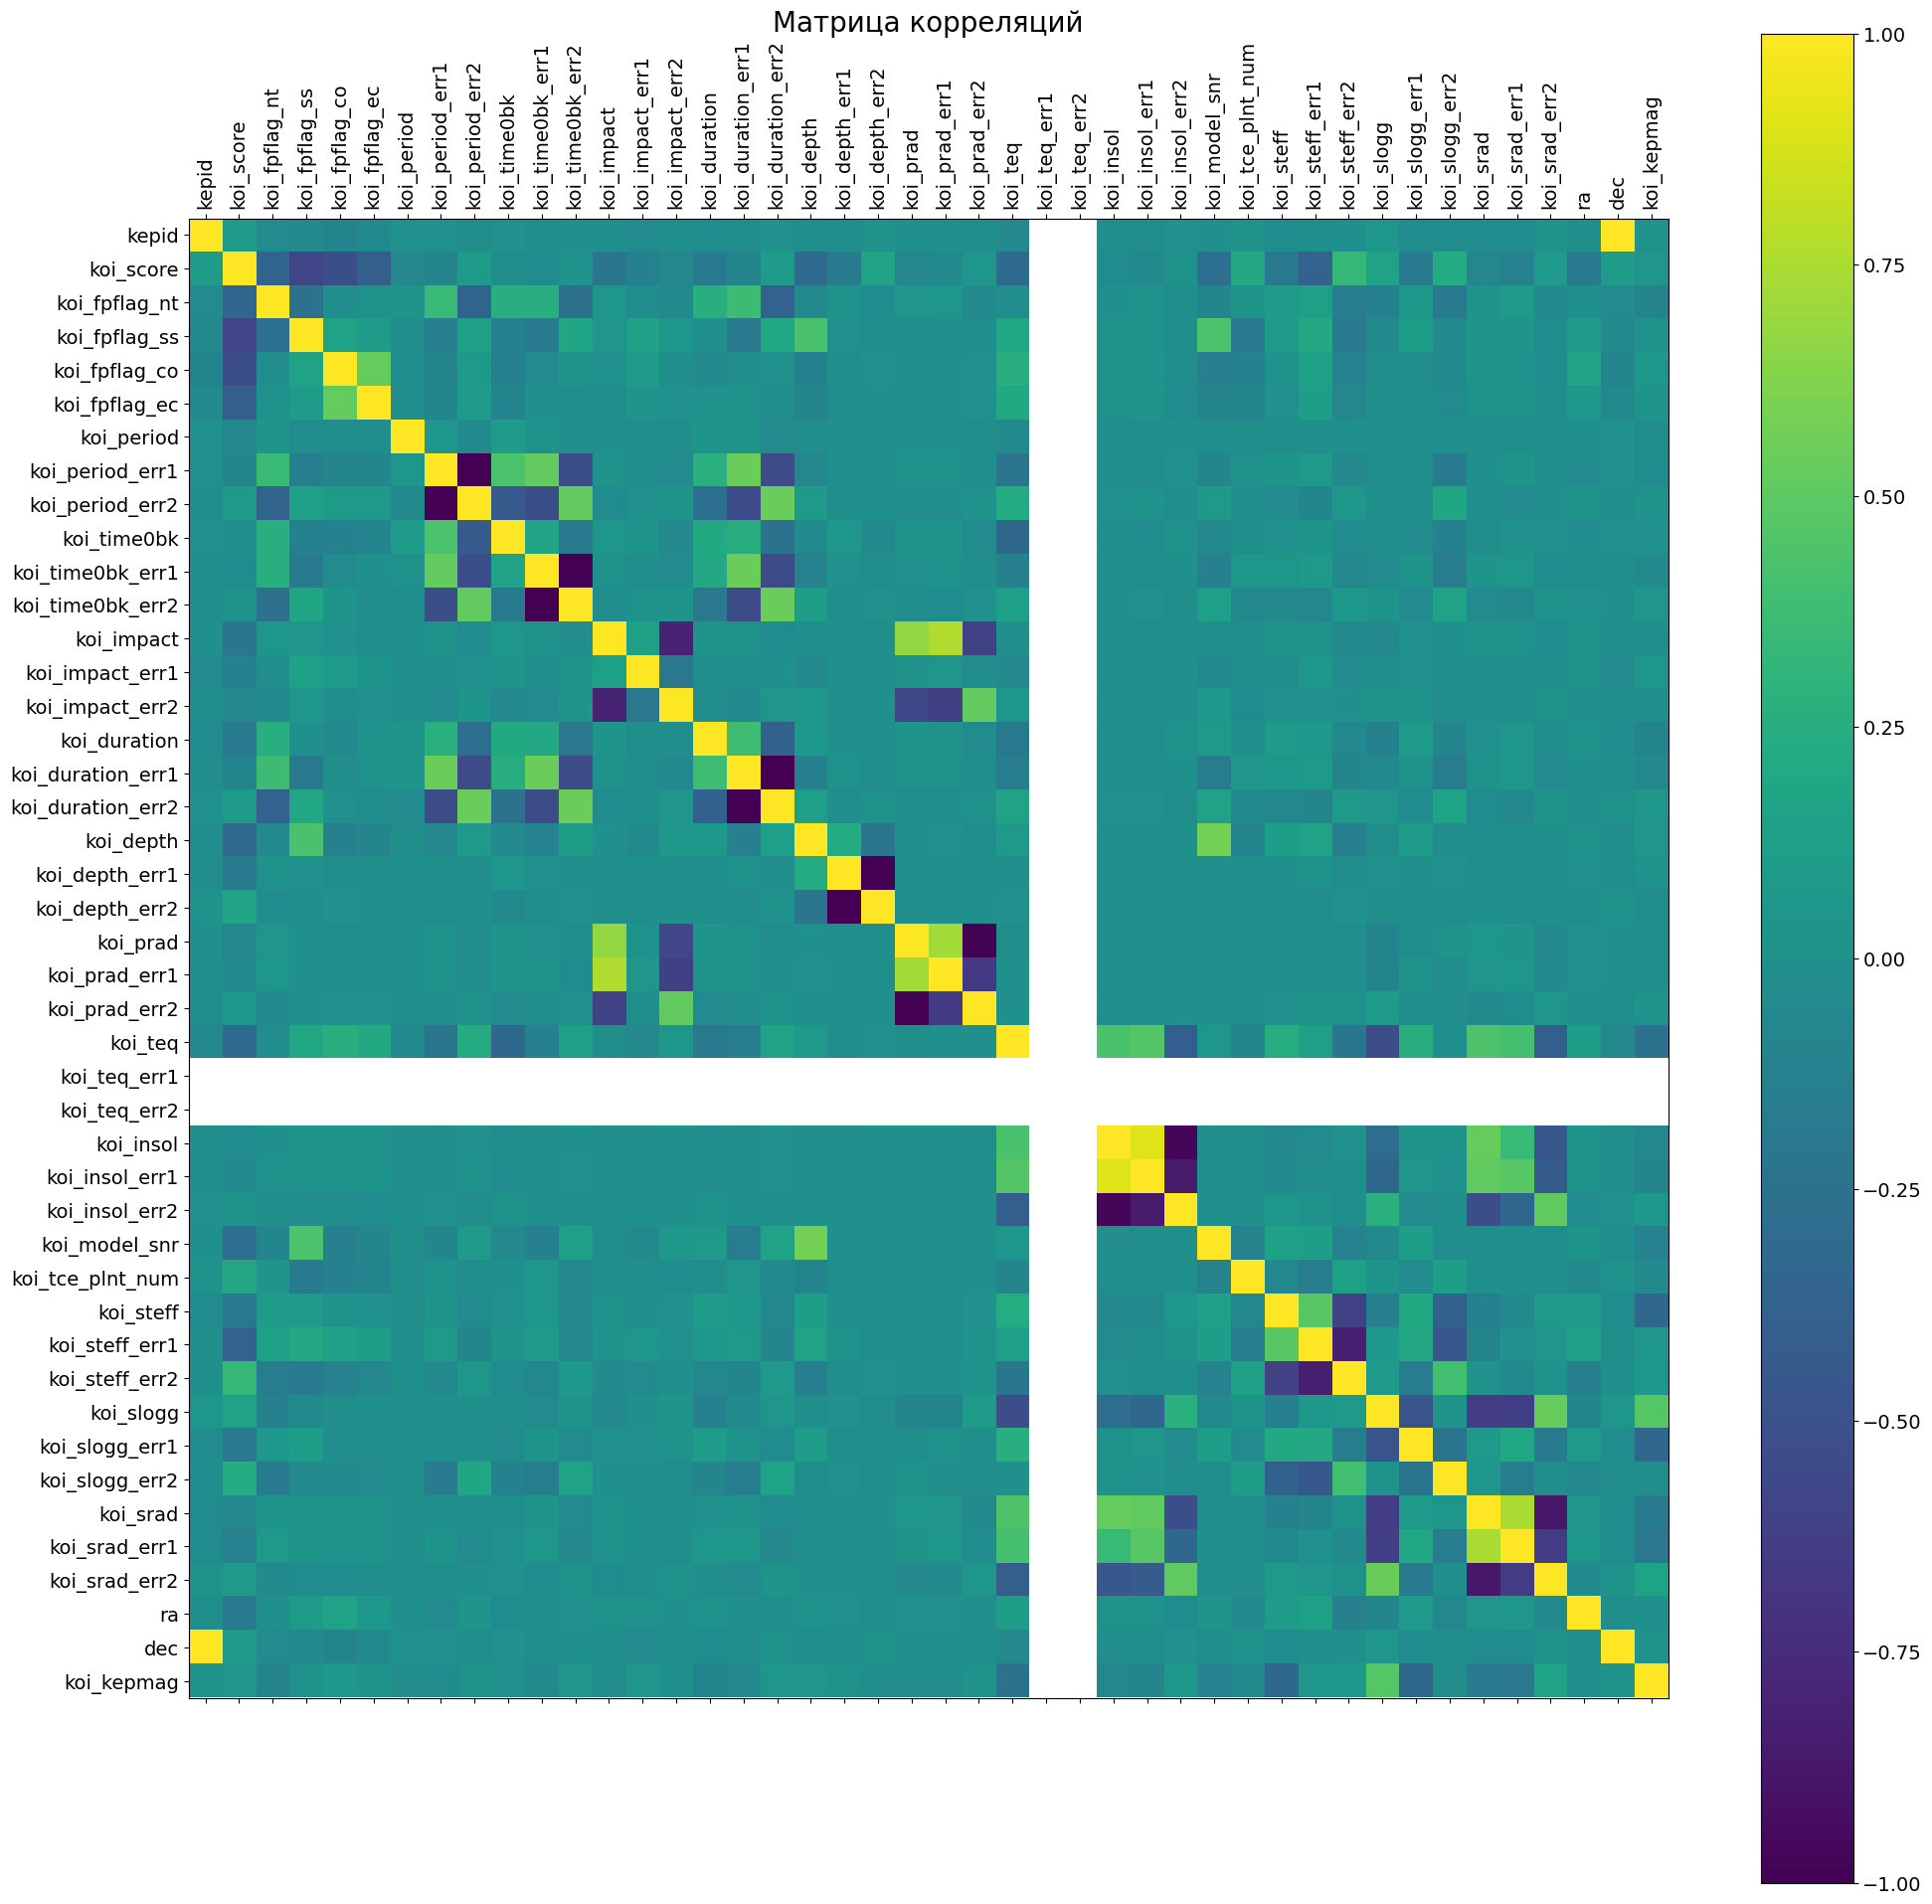

In [41]:
f = plt.figure(figsize=(24, 24))
plt.matshow(df.corr(numeric_only=True), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляций', fontsize=20);


In [21]:

corr_matrix = df.drop(cols_to_exclude, axis=1).corr()

# Находим самые коррелирующие пары переменных
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# Выводим самые коррелирующие пары переменных
print('Самые коррелирующие пары переменных:')
seen_pairs = set()
for pair, corr in sorted_pairs.items():
    var1, var2 = pair
    if var1 != var2 and corr != 1.0:
        if (var1, var2) not in seen_pairs and (var2, var1) not in seen_pairs:
            print(f'{var1} - {var2}: {corr:.2f}')
            seen_pairs.add((var1, var2))

Самые коррелирующие пары переменных:
kepid - dec: 0.99
koi_prad - koi_impact: 0.68
koi_model_snr - koi_depth: 0.58
koi_srad - koi_insol: 0.53
koi_fpflag_ec - koi_fpflag_co: 0.53
koi_kepmag - koi_slogg: 0.47
koi_srad - koi_teq: 0.44
koi_model_snr - koi_fpflag_ss: 0.43
koi_fpflag_ss - koi_depth: 0.42
koi_insol - koi_teq: 0.42
koi_fpflag_nt - koi_duration: 0.26
koi_teq - koi_fpflag_co: 0.25
koi_time0bk - koi_fpflag_nt: 0.25
koi_teq - koi_steff: 0.24
koi_teq - koi_fpflag_ec: 0.22
koi_time0bk - koi_duration: 0.22
koi_score - koi_tce_plnt_num: 0.21
koi_fpflag_ss - koi_teq: 0.19
ra - koi_fpflag_co: 0.16
koi_slogg - koi_score: 0.15
koi_fpflag_ss - koi_fpflag_co: 0.15
koi_model_snr - koi_steff: 0.14
ra - koi_teq: 0.12
koi_depth - koi_steff: 0.11
koi_fpflag_nt - koi_steff: 0.11
koi_steff - ra: 0.11
koi_steff - koi_duration: 0.11
koi_fpflag_ss - koi_steff: 0.10
koi_fpflag_ss - koi_fpflag_ec: 0.10
koi_time0bk - koi_period: 0.10
koi_score - kepid: 0.10
koi_score - dec: 0.09
ra - koi_fpflag_ss: 0.09

C:\Users\kirill\AppData\Local\Temp\ipykernel_17256\2709365271.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.drop(cols_to_exclude, axis=1).corr()


In [40]:
from sklearn.ensemble import RandomForestClassifier

# Загрузка данных

# Выбор переменных, оканчивающихся на _err1 и _err2
err_cols = [col for col in df.columns if col.endswith('_err1') or col.endswith('_err2')]

# Подготовка данных для обучения
X = df[err_cols]
y = df['koi_disposition']

# Удаление строк с пустыми значениями
X.fillna(0, inplace=True)

# Кодирование категориальной переменной koi_disposition
y_encoded = pd.factorize(y)[0]

# Вычисление корреляции между переменными
correlations = {}
for col in X.columns:
    correlations[col] = sts.spearmanr(X[col], y_encoded)[0]

# Вывод корреляций
correlations = pd.Series(correlations)
correlations.sort_values(ascending=False, inplace=True)
print(correlations)

koi_duration_err1    0.236310
koi_time0bk_err1     0.216986
koi_srad_err1        0.168580
koi_steff_err1       0.152906
koi_period_err1      0.117056
koi_depth_err1       0.110466
koi_prad_err1        0.065773
koi_slogg_err1       0.028229
koi_impact_err2      0.027670
koi_impact_err1      0.017432
koi_insol_err1       0.015960
koi_insol_err2       0.004000
koi_prad_err2       -0.006719
koi_srad_err2       -0.072305
koi_depth_err2      -0.110466
koi_period_err2     -0.117056
koi_slogg_err2      -0.135826
koi_steff_err2      -0.157065
koi_time0bk_err2    -0.216986
koi_duration_err2   -0.236310
koi_teq_err1              NaN
koi_teq_err2              NaN
dtype: float64


C:\Users\kirill\AppData\Local\Temp\ipykernel_17256\3336231458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)
c:\Users\kirill\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
